In [1]:
import matplotlib.pyplot as plt
import numpy as np

from numpy.typing import NDArray

from karabo.imaging.image import Image
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.imaging.util import project_sky_to_image
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

from karabo.simulation.sample_simulation import run_sample_simulation

# Render plots inline
%matplotlib inline

In [2]:
phase_center = [250, -80]
visibilities, sky = run_sample_simulation(phase_center=phase_center, verbose=True)

Getting Sky Survey
Filtering Sky Model
Setting Up Telescope
Setting Up Observation
Generating Visibilities
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-CNAnQPs5aB for visibility disk-cache
Saving file to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-CNAnQPs5aB/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-XEcxndmID0 for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-CNAnQPs5aB/visibility.vis


### Source Detection

In [3]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

In [4]:
ground_truth, sky_idxs = project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

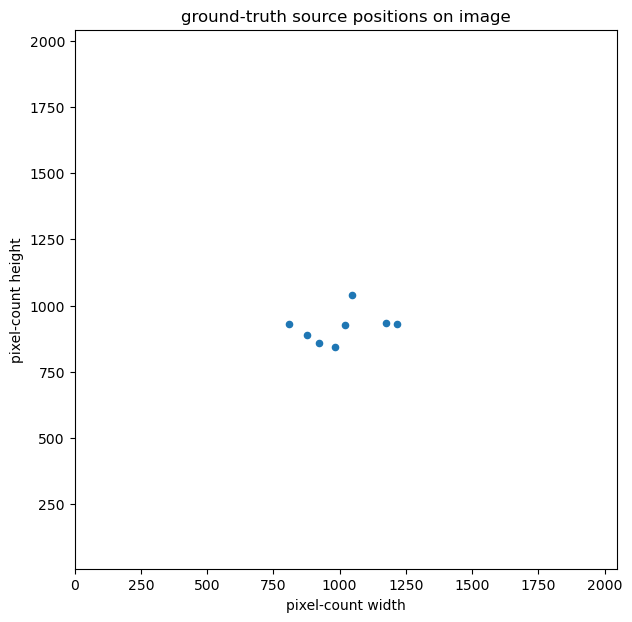

In [5]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [6]:
def detect_sources_and_evaluate(
    image: Image,
    ground_truth: NDArray[np.float64],
    sky: SkyModel,
    sky_idxs: NDArray[np.int64],
) -> SourceDetectionEvaluation:
    detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(
        image=image,
        thresh_isl=15,
        thresh_pix=20,
    )

    assignments = (
        SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
            ground_truth=ground_truth.T,
            detected=detection_result.get_pixel_position_of_sources(),
            max_dist=10,
            top_k=3,
        )
    )
    print(assignments)

    sde = SourceDetectionEvaluation(
        sky=sky,
        ground_truth=ground_truth,
        assignments=assignments,
        sky_idxs=sky_idxs,
        source_detection=detection_result,
    )
    sde.plot()

    sde.plot_confusion_matrix()

    return sde

#### WSClean

Generate a cleaned image with WSClean to showcase the source_detection capabilities. For more examples on imaging, see the imaging.ipynb example notebook.

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-gwJwlW8Pnn for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-gwJwlW8Pnn && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-XEcxndmID0/measurements.MS]


WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-XEcxndmID0/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Detected 15.5 GB of system memory, usage not limited.
Opening /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-XEcxndmID0/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Determining min and max w & theoretical beam size... DONE (w=[0.00172035:1905.5] lambdas, maxuvw=2148.94 lambda)
Theoretic beam = 95.98''
Minimal inver

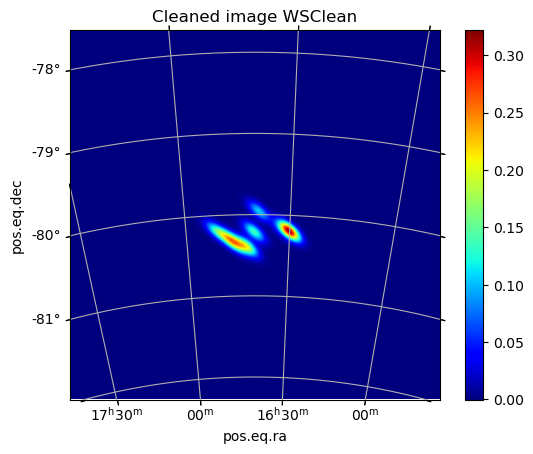

In [7]:
dirty_wsclean = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibilities)

restored_wsclean = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(
    ms_file_path=visibilities.ms_file_path,
)
restored_wsclean.plot(title="Cleaned image WSClean")

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-WUEj4d13vY for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-WUEj4d13vY/sources.csv'
--> Wrote file '/tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-WUEj4d13vY/ch0-result.fits'
[[0.         4.         1.33941326]
 [1.         7.         2.87344828]
 [2.         1.         3.21856206]
 [3.         0.         1.40390851]
 [4.         2.         1.40511695]
 [5.         6.         7.15305314]
 [6.         5.         1.32235141]
 [7.         3.         1.40077582]]


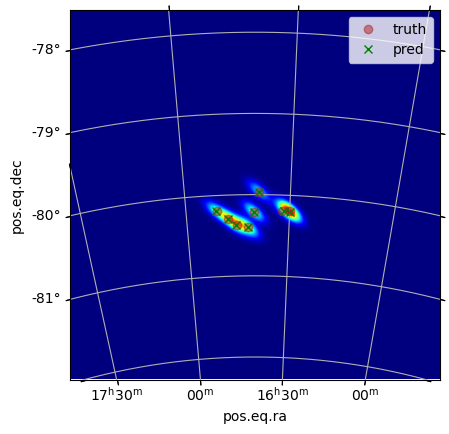

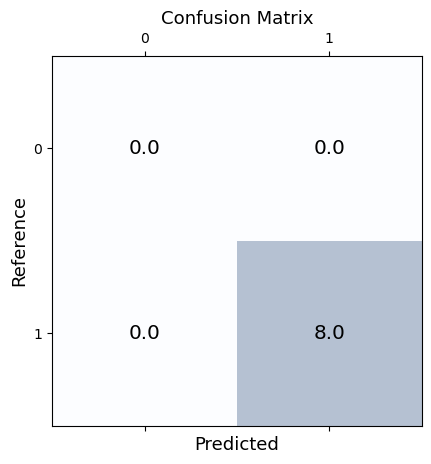

In [8]:
sde_restored_wsclean = detect_sources_and_evaluate(
    image=restored_wsclean, ground_truth=ground_truth, sky=sky, sky_idxs=sky_idxs
)

#### Additional plots

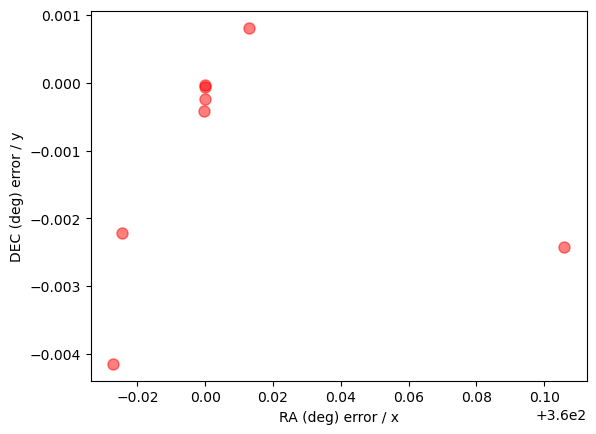

In [9]:
# Plot error ra and dec
sde_restored_wsclean.plot_error_ra_dec()

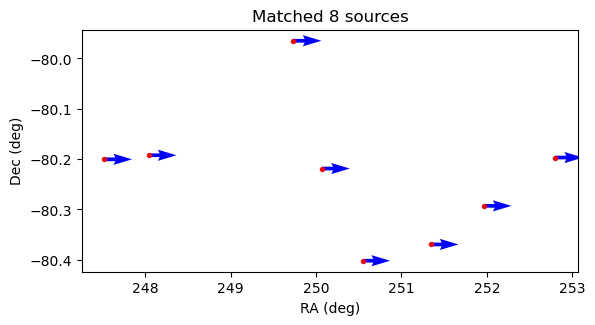

In [10]:
sde_restored_wsclean.plot_quiver_positions()

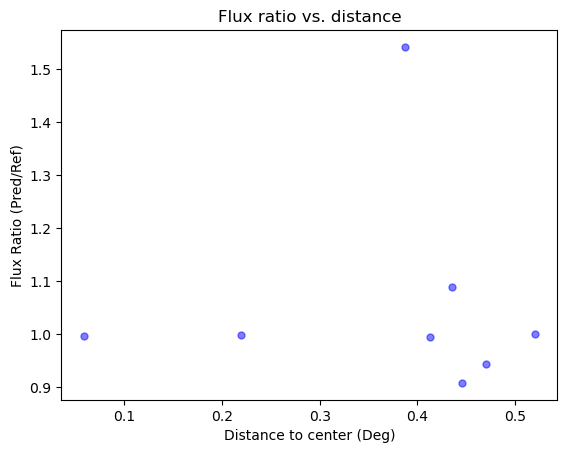

In [11]:
sde_restored_wsclean.plot_flux_ratio_to_distance()

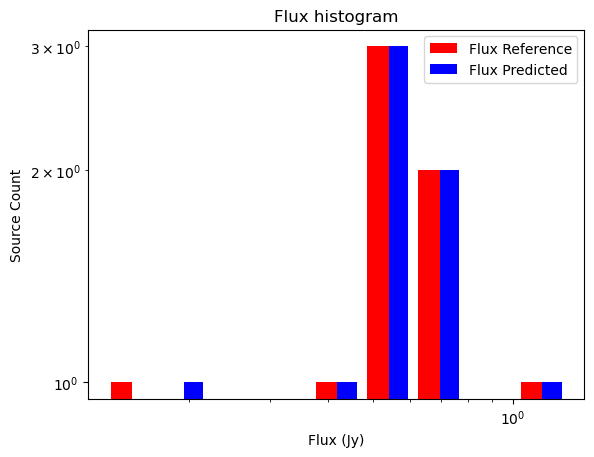

In [12]:
sde_restored_wsclean.plot_flux_histogram()

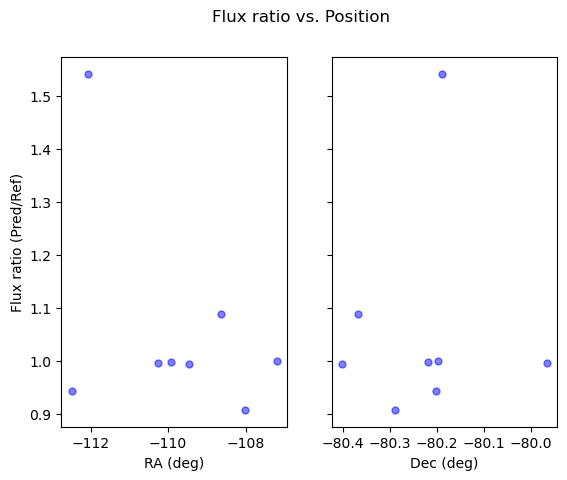

In [13]:
sde_restored_wsclean.plot_flux_ratio_to_ra_dec()